### 1. Load Modules

In [225]:
import pandas as pd
pd.set_option('display.max_columns', 101)
pd.set_option('display.max_rows', 101)
pd.options.mode.chained_assignment = None
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# import lightgbm as lgb
import xgboost as xgb
import gc

In [2]:
def set_labels(ax, total, title, x_label, y_label):
    '''this function set plot title and labels'''
    ax.set_title(title, fontsize=22)
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=15) 

def plot_dist_and_fraud_pct(df, col):
    '''this function draws the distribution of categorical values and percentage of transaction frauds per value'''
    df_bar = (df.groupby([col])['isFraud'].mean()*100).reset_index() 
    plt.figure(figsize=(16,6))
    g = sns.countplot(x=col, data=df, order=list(df_bar[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='isFraud', data=df_bar, 
                        color='black', order=list(df_bar[col].values))
    gt.set_ylabel("% of Fraud Transactions", fontsize=10)
    g.set_title("{} Values Distribution and % of Transaction Frauds".format(col), fontsize=12)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_xlabel("{} Values".format(col), fontsize=10)
    g.set_ylabel("Count", fontsize=10)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/len(df)*100),
                ha="center",fontsize=11) 
    plt.show()
    
def keep_top_levels(df, col, explained_ratio = 0.95):
    '''this function describe top levels with most reocrds of selected feature'''
    df_sum = df[col].value_counts().sort_values(ascending = False).reset_index()
    df_sum.columns = ['feature','count']
    df_sum['cumsum_pct'] = np.round(100*(df_sum['count'].cumsum()/df_sum['count'].sum()),1)

    top_levels = df_sum.loc[df_sum['cumsum_pct'] <= explained_ratio*100, 'feature'].values.tolist()
    
    if len(top_levels) < 2:
        top_levels = df_sum.loc[:1, 'feature'].values.tolist()
    print('------------------------------------------------------------------------------------------------------------')
    print('{} has {} unique levels.'.format(col, len(df_sum)))
    print('top {} levels account for {}% of the total population.'.format(len(top_levels),
                                                                round(df_sum[df_sum['feature'].isin(top_levels)]['cumsum_pct'].max(),2)))
    
    if df[col].nunique() > len(top_levels) + 1:
        df.loc[:, col] = np.where(df[col].isin(top_levels), df[col], 'Others')
    
    return df, top_levels

def plot_missing_pct(df, features, feature_name):
    '''this function draw bar plot of missing value percentage '''
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    
    ax.bar(features, df[features].isnull().mean())
    ax.set_ylim(0,1)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('% missing data')
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    plt.title('Percentage of missing values of {}'.format(feature_name))
    plt.show()
    
def pca_transform(df, features, explained_var_ratio = 0.95, prefix = 'PCA_'):
    '''this function conducts pca transformation to reduce dimension'''
    # drop na cols where missing value % > 0.9
    filtered_features = df[features].isnull().mean().where(lambda x: x<0.9).dropna().index.values
    
    # fill na
    df.loc[:, filtered_features] = df[filtered_features].fillna(-1)
    
    # scale
    scaler = MinMaxScaler()
    scaledArr = scaler.fit_transform(df[filtered_features])
    scaledDF = pd.DataFrame(scaledArr, index=df.index, columns= filtered_features)
    
    # PCA
    pca = PCA(explained_var_ratio, random_state = 0)
    principalComponents = pca.fit_transform(scaledDF)
    principalDF = pd.DataFrame(principalComponents, columns = [prefix+str(x) for x in range(1, principalComponents.shape[1]+1)])
    
    df.drop(features, axis=1, inplace=True)
    df = pd.concat([df, principalDF], axis=1)
    
    return df, scaler, pca

def scree_plot(pca):
    '''this function creates a scree plot associated with the principal components.'''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.show()
    
    cumvals = np.cumsum(pca.explained_variance_ratio_)
    print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

### 2. Import Data

In [3]:
# data folder path
data_path = '../data'

# data file name
train_id_file = 'train_identity.csv'
train_trans_file = 'train_transaction.csv'
# test_id_file = 'test_identity.csv'
# test_trans_file = 'test_transaction.csv'

# read data file as pd dataframe
train_id = pd.read_csv(os.path.join(data_path, train_id_file))
train_trans = pd.read_csv(os.path.join(data_path, train_trans_file))
# test_id = pd.read_csv(os.path.join(data_path, test_id_file))
# test_trans = pd.read_csv(os.path.join(data_path, test_trans_file))

# merge id and transcation dfs
train = pd.merge(train_trans, train_id, on='TransactionID', how='left')
# test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

In [4]:
# print df shape
print('Train dataset has {} rows and {} columns.'.format(train.shape[0], train.shape[1]))
# print('Test dataset has {} rows and {} columns.'.format(test.shape[0], test.shape[1]))

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [5]:
# delete initial dfs
del train_id, train_trans
# del train_id, train_trans, test_id, test_trans

### 3. EDA

In [6]:
# columns with missing value 
print('There are {} columns in train dataset with missing values.'.format(train.isnull().any().sum()))
print('There are {} columns in test dataset with missing values.'.format(test.isnull().any().sum()))

There are 414 columns in train dataset with missing values.
There are 385 columns in test dataset with missing values.


In [7]:
# columns with uni-value 
print('There are {} columns in train dataset with one unique value.'.format(sum(train.nunique() == 1)))
print('There are {} columns in test dataset with one unique value.'.format(sum(test.nunique() == 1)))

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


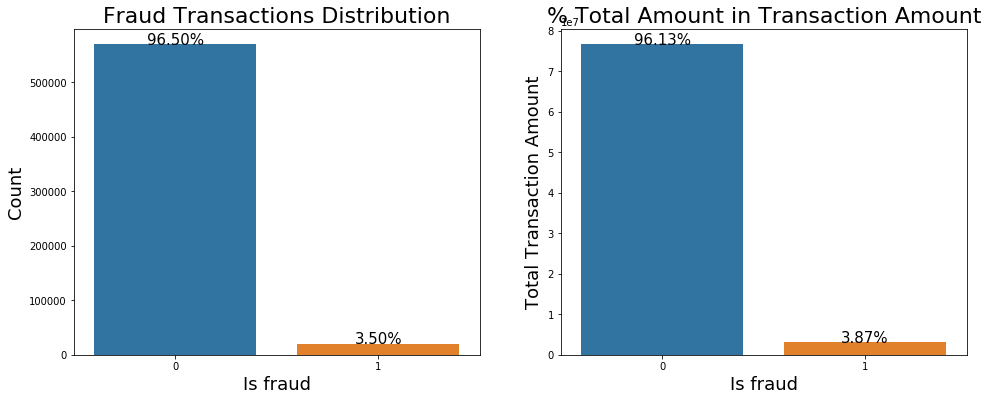

In [8]:
# plot fraud distribution by count and total amount
plt.figure(figsize=(16,6))
plt.subplot(121)
ax = sns.countplot(x='isFraud', data=train)
set_labels(ax, len(train), 'Fraud Transactions Distribution', 'Is fraud', 'Count')
plt.subplot(122)
df_bar = train.groupby(['isFraud'])['TransactionAmt'].sum().reset_index()
ax = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=df_bar)
set_labels(ax, df_bar['TransactionAmt'].sum(), '% Total Amount in Transaction Amount', 'Is fraud', 'Total Transaction Amount')

### 4. Feature Engineering

#### 4.1 Categorical Features

##### 4.1.1 ProductCD feature

In [231]:
df = train.copy()

In [232]:
cate_features = []

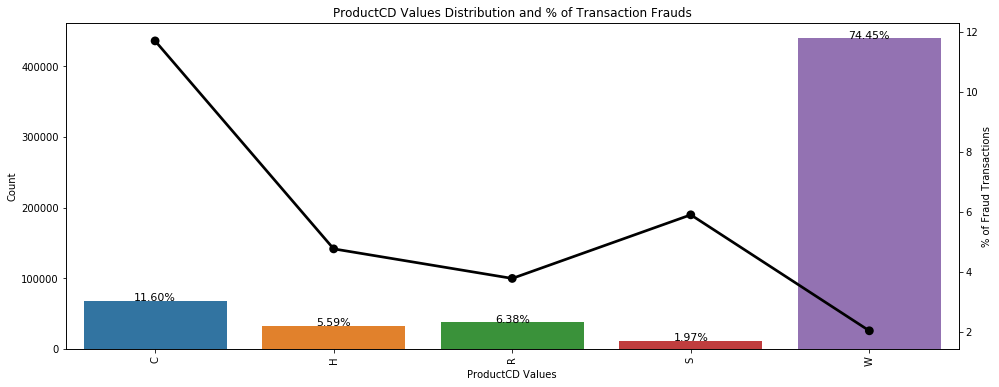

In [233]:
# plot productCD feature
plot_dist_and_fraud_pct(df, 'ProductCD')
cate_features.append('ProductCD')

##### 4.1.2 email features - P_emaildomain, R_emaildomain

In [234]:
# email features: P_emaildomain, R_emaildomain
# email map
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# clean email domains
df = df.assign(P_emaildomain_bin = df['P_emaildomain'].map(emails),
          P_emaildomain_suffix = df['P_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
          R_emaildomain_bin = df['R_emaildomain'].map(emails),
          R_emaildomain_suffix = df['R_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
        )

df.drop(['P_emaildomain', 'R_emaildomain'], axis=1, inplace=True)

In [235]:
cate_features.extend(['P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix'])

##### 4.1.3 deveice features - DeviceInfo, DeviceType

In [236]:
# deveice features: DeviceInfo, DeviceType
# device map
devices = {'SM': 'Samsung', 'SAMSUNG': 'Samsung', 'GT-': 'Samsung', 'Moto G': 'Motorola',
           'Moto': 'Motorola', 'moto': 'Motorola', 'LG-': 'LG', 'VS\d{3}': 'LG', 'LG\w{2}\d{3}': 'LG', 'rv': 'RV', 'HUAWEI': 'Huawei',
           'ALE-':'Huawei', '-L':'Huawei', 'hi6210sft': 'Huawei', 'CHC-U03': 'Huawei', 'Blade': 'ZTE', 'Z\d{3}': 'ZTE', 'BLADE': 'ZTE', 'ZTE':'ZTE', 
           'Linux': 'Linux', 'XT': 'Sony', 'F\d{4}': 'Sony', 'E\d{4}': 'Sony', 'G\d{4}': 'Sony', 'HTC': 'HTC', 'ASUS': 'Asus',
           'Pixel': 'Pixel', 'Lenovo': 'Lenovo', 'Windows': 'Windows', 'Redmi': 'Redmi', 'Ilium': 'Ilium', 'ILIUM': 'Ilium',
           'Hisense': 'Hisense', 'KF': 'Amazon', 'Android': 'Android', '\d{4}A': 'Alcatel', '\d{4}W': 'Alcatel', '\d{4}M': 'Alcatel', 
           'Alcatel': 'Alcatel', 'ALCATEL':'Alcatel', '\d{4}G': 'Mozilla', 'M4': 'M4', 'TA-': 'Nokia', 'NOKIA': 'Nokia', 'Nexus':'Nexus', 'BLU':'BLU'}

# devices_list = df.loc[:,'device_name'].value_counts().where(lambda x : x>80).dropna().index.values

devices_list = ['None', 'Windows', 'iOS Device', 'MacOS', 'Samsung', 'Trident', 'RV',
               'Motorola', 'LG', 'Huawei', 'Sony', 'ZTE', 'HTC', 'Alcatel', 'Lenovo',
               'Ilium', 'Pixel', 'Hisense', 'Amazon', 'Mozilla', 'M4', 'Redmi',
               'Nokia', 'Linux', 'Nexus', 'Android']

# clean device name
df.loc[:,'DeviceName'] = df['DeviceInfo'].str.split('/').str[0].fillna('None')
for k,v in devices.items():
    df.loc[df['DeviceName'].str.contains(k, na=False), 'DeviceName'] = v
df.loc[~df['DeviceName'].isin(devices_list), 'DeviceName'] = 'Others'

# remove DeviceInfo
df.drop(['DeviceInfo'], axis=1, inplace=True)

# DeviceType - fillna
df.loc[:,'DeviceType'] = df['DeviceType'].fillna('None')

In [237]:
cate_features.extend(['DeviceName', 'DeviceType'])

##### 4.1.4 other categorical features - address features, card features, M features

       nunique
card1    13553
card2      500
addr1      332
card5      119
card3      114
addr2       74
card6        4
card4        4
M4           3
M9           2
M8           2
M2           2
M3           2
M5           2
M6           2
M7           2
M1           2
------------------------------------------------------------------------------------------------------------
addr1 has 333 unique levels.
top 37 levels account for 94.6% of the total population.
------------------------------------------------------------------------------------------------------------
addr1 has 38 unique levels.
top 18 levels account for 79.4% of the total population.


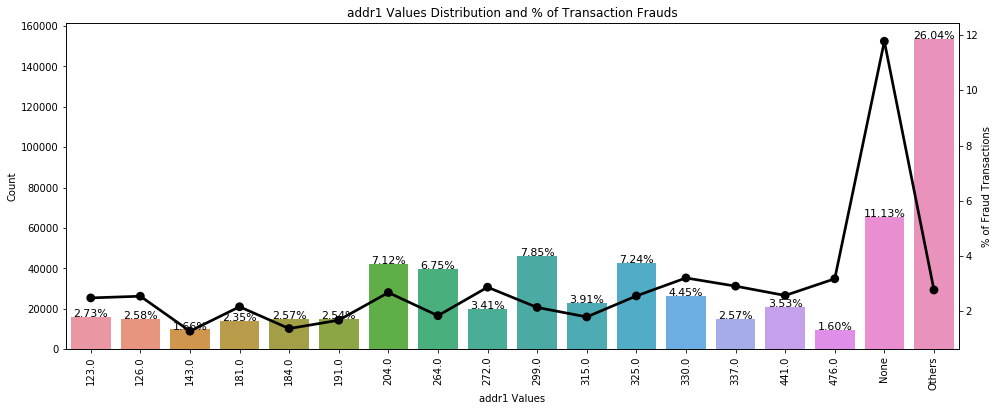

------------------------------------------------------------------------------------------------------------
addr2 has 75 unique levels.
top 2 levels account for 99.3% of the total population.


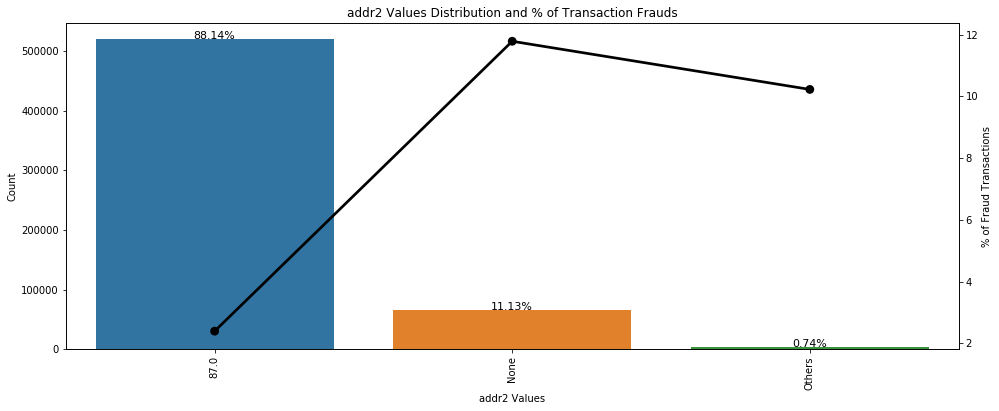

------------------------------------------------------------------------------------------------------------
card2 has 501 unique levels.
top 229 levels account for 95.0% of the total population.
------------------------------------------------------------------------------------------------------------
card2 has 230 unique levels.
top 40 levels account for 80.0% of the total population.


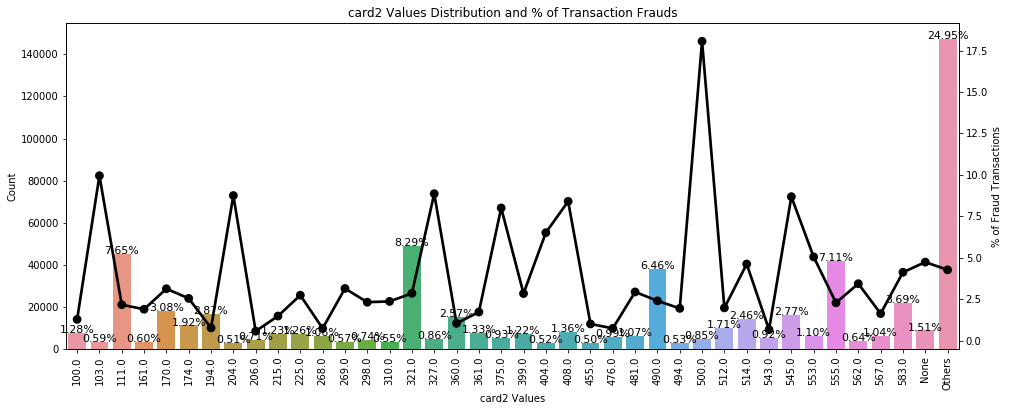

------------------------------------------------------------------------------------------------------------
card3 has 115 unique levels.
top 2 levels account for 97.8% of the total population.


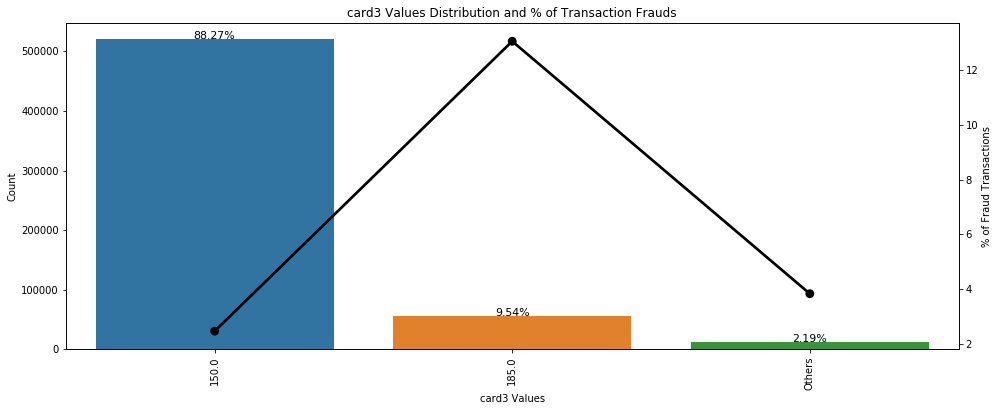

------------------------------------------------------------------------------------------------------------
card4 has 5 unique levels.
top 2 levels account for 97.2% of the total population.


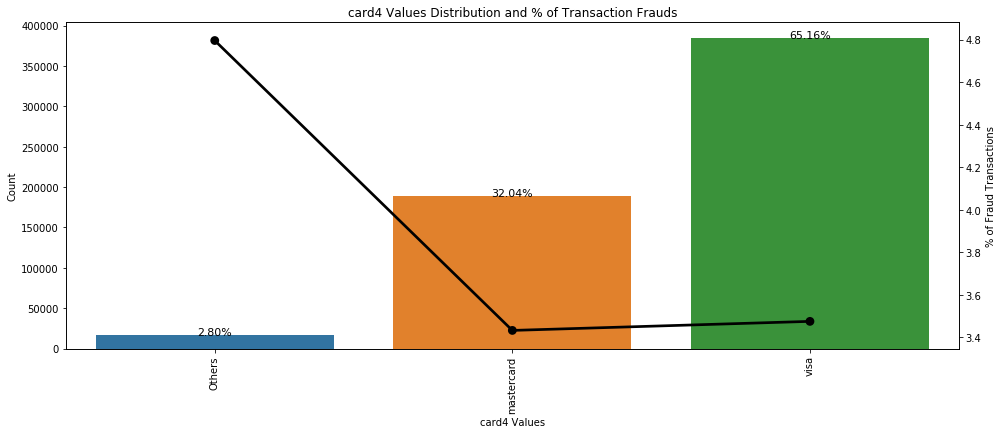

------------------------------------------------------------------------------------------------------------
card5 has 120 unique levels.
top 10 levels account for 94.6% of the total population.
------------------------------------------------------------------------------------------------------------
card5 has 11 unique levels.
top 6 levels account for 88.4% of the total population.


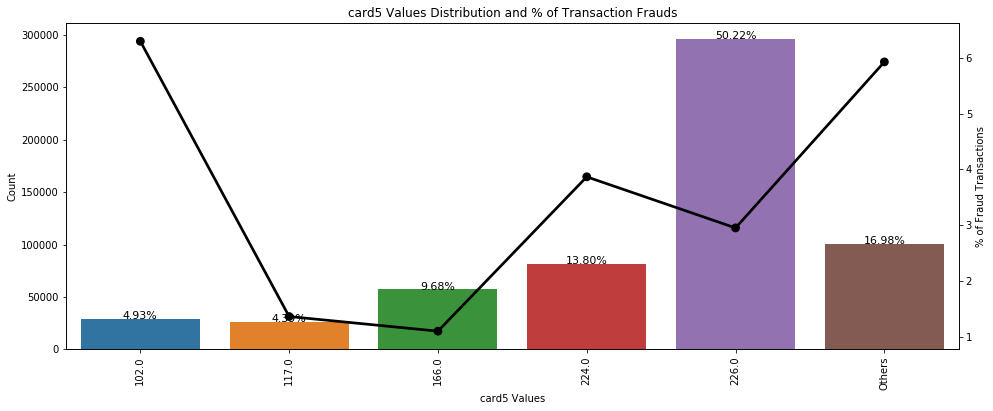

------------------------------------------------------------------------------------------------------------
card6 has 5 unique levels.
top 2 levels account for 99.7% of the total population.


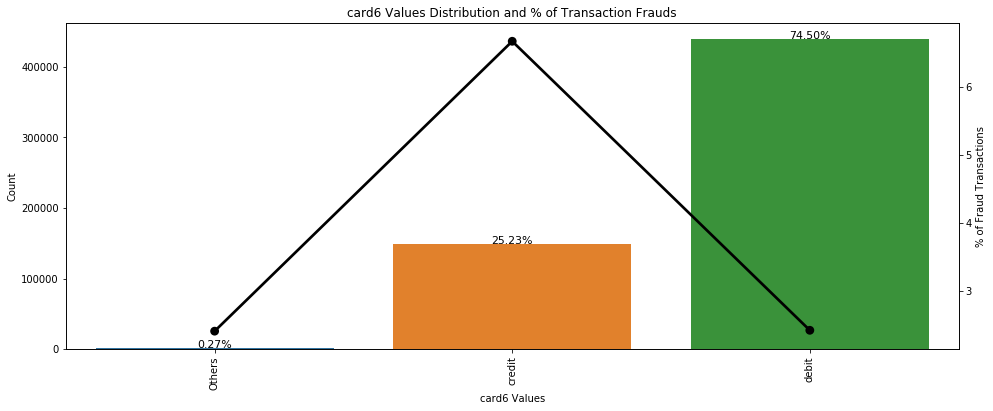

------------------------------------------------------------------------------------------------------------
M1 has 3 unique levels.
top 2 levels account for 100.0% of the total population.


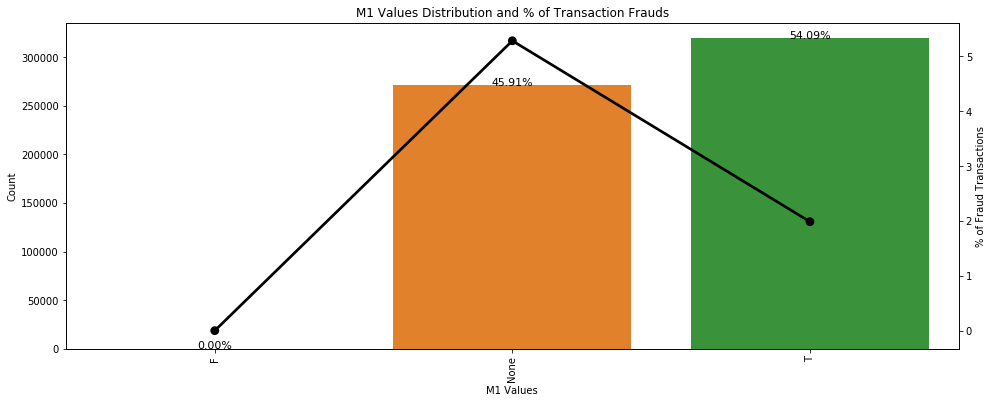

------------------------------------------------------------------------------------------------------------
M2 has 3 unique levels.
top 2 levels account for 94.2% of the total population.


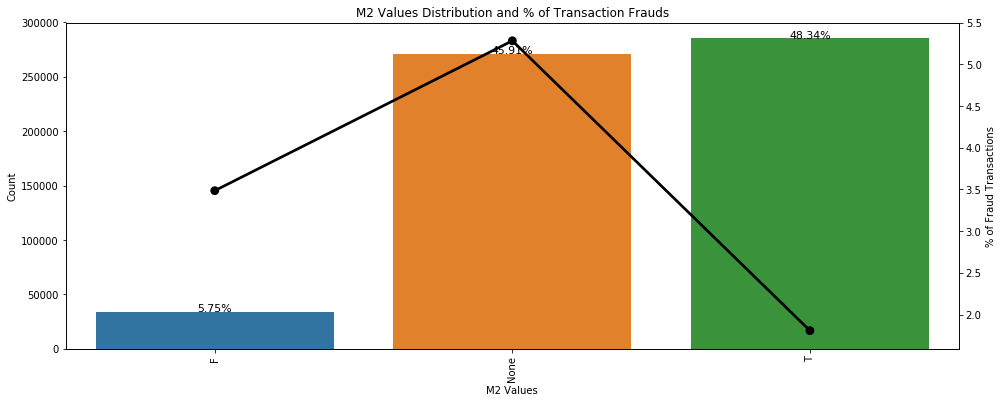

------------------------------------------------------------------------------------------------------------
M3 has 3 unique levels.
top 2 levels account for 88.5% of the total population.


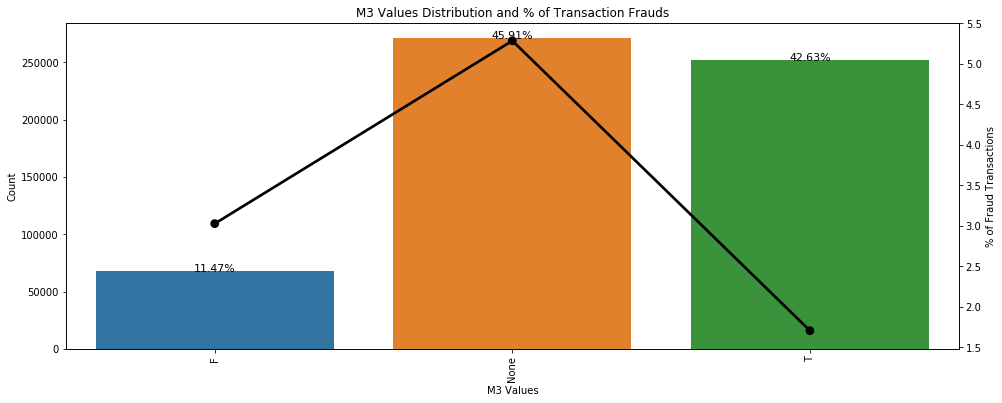

------------------------------------------------------------------------------------------------------------
M4 has 4 unique levels.
top 3 levels account for 91.1% of the total population.


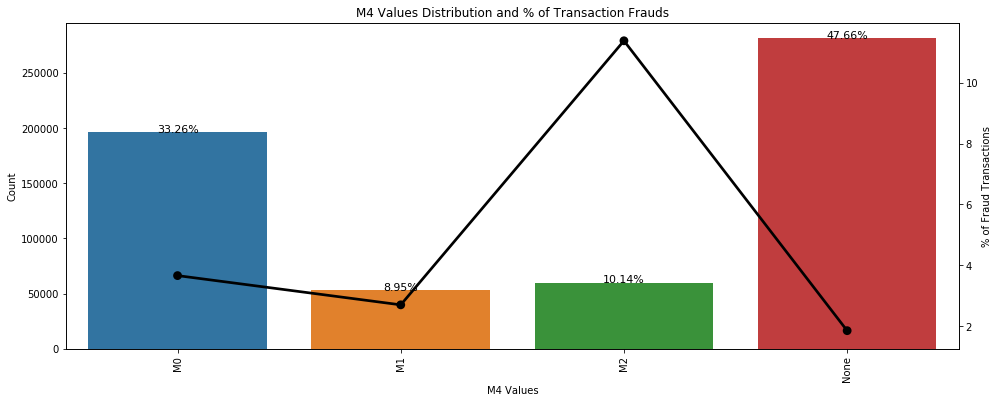

------------------------------------------------------------------------------------------------------------
M5 has 3 unique levels.
top 2 levels account for 81.8% of the total population.


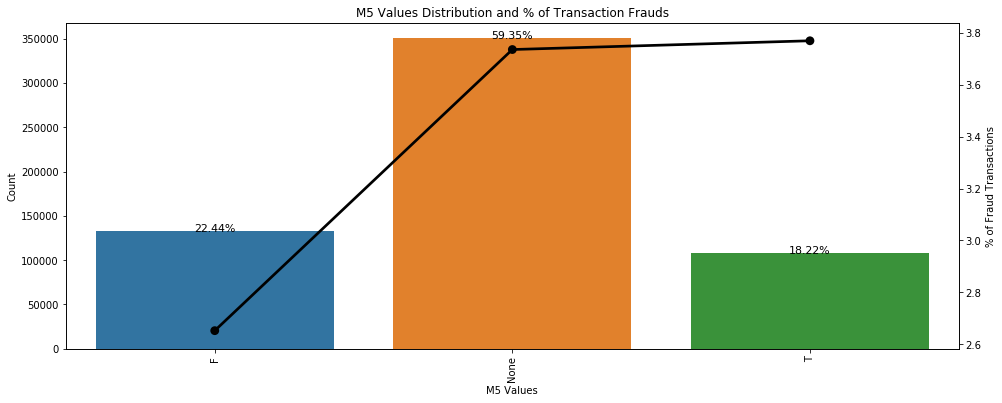

------------------------------------------------------------------------------------------------------------
M6 has 3 unique levels.
top 2 levels account for 71.3% of the total population.


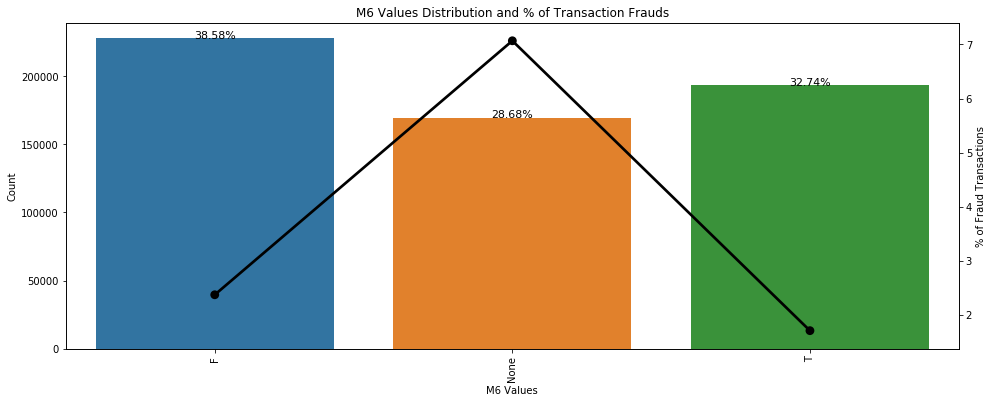

------------------------------------------------------------------------------------------------------------
M7 has 3 unique levels.
top 2 levels account for 94.4% of the total population.


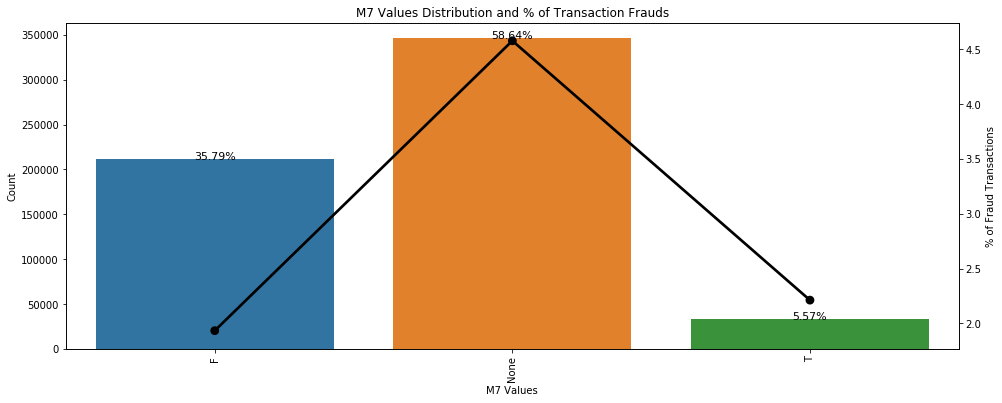

------------------------------------------------------------------------------------------------------------
M8 has 3 unique levels.
top 2 levels account for 84.9% of the total population.


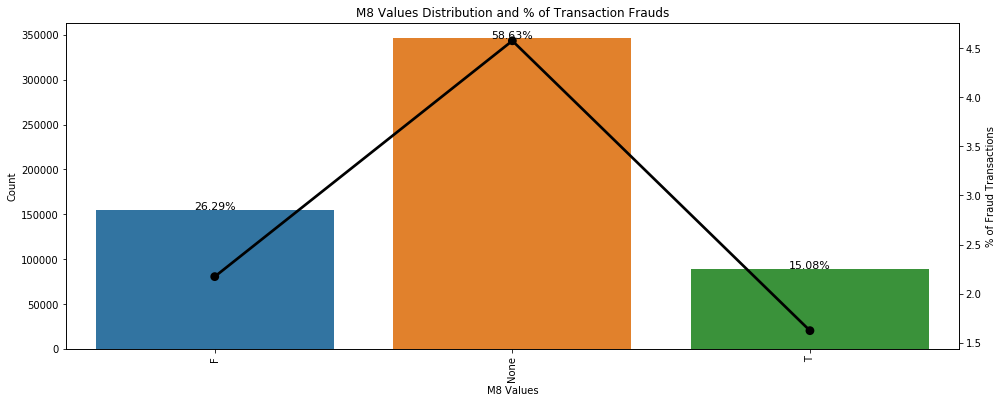

------------------------------------------------------------------------------------------------------------
M9 has 3 unique levels.
top 2 levels account for 93.5% of the total population.


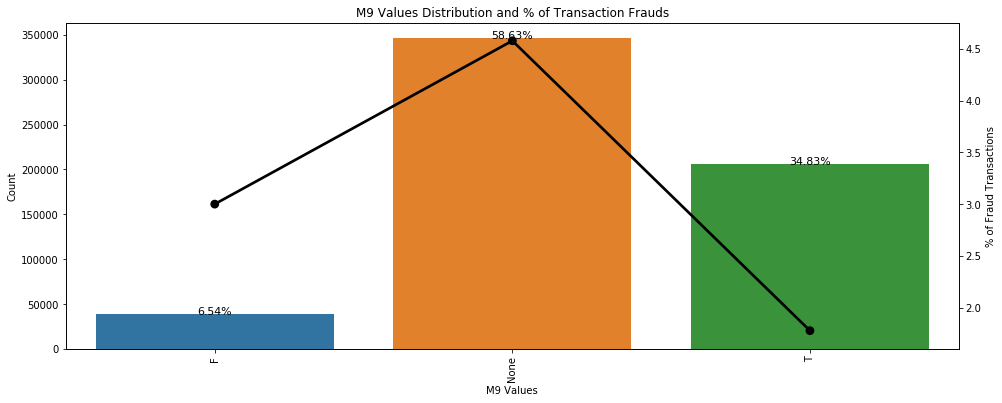

In [238]:
# categorical features (address, card, M features)
addr_features = df.columns[df.columns.str.contains('addr')].values.tolist()
card_features = df.columns[df.columns.str.contains('card')].values.tolist()
m_features = df.columns[df.columns.str.contains('M\d+')].values.tolist()

# unique levels
print(pd.DataFrame(df[addr_features+card_features+m_features].nunique().sort_values(ascending=False), columns = ['nunique']))

# remove card1 due to too much levels
df.drop(['card1'], axis=1, inplace=True)
card_features.remove('card1')

# fill na
df.loc[:, addr_features+card_features+m_features] = df[addr_features+card_features+m_features].fillna('None')

# int to float
features_to_int = df[addr_features+card_features].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, features_to_int] = df.loc[:, features_to_int].astype('Int64')

# int to str
df.loc[:, addr_features+card_features] = df.loc[:, addr_features+card_features].astype(str)

# clean categorical features
for col in addr_features+card_features+m_features:
    df, top_levels = keep_top_levels(df, col)
    if len(top_levels) > 10:
        df, top_levels = keep_top_levels(df, col, 0.8)
    elif len(top_levels) > 5:
        df, top_levels = keep_top_levels(df, col, 0.9)
    plot_dist_and_fraud_pct(df, col)

In [239]:
cate_features.extend(addr_features+card_features+m_features)

#### 4.2 Numerical Features

##### 4.2.1 V, C, D feature - PCA

In [240]:
num_features = []

In [241]:
# numerical features (v, c, d features)
v_features = df.columns[df.columns.str.contains('V\d+')].values.tolist()
c_features = df.columns[df.columns.str.contains('C\d+')].values.tolist()
d_features = df.columns[df.columns.str.contains('D\d+')].values.tolist()

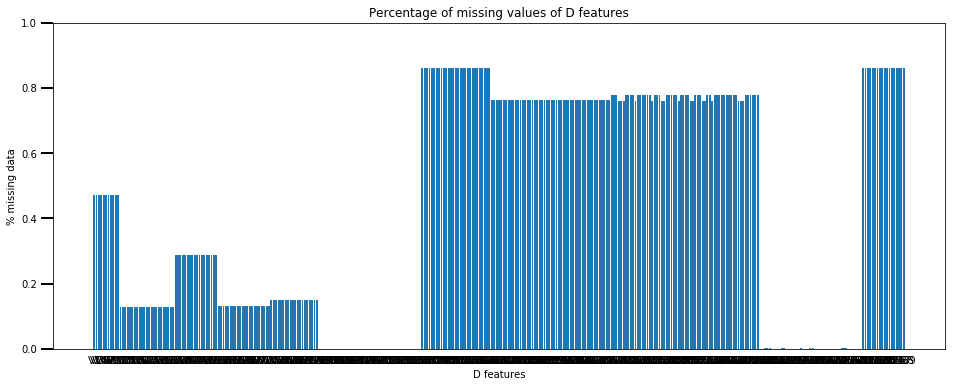

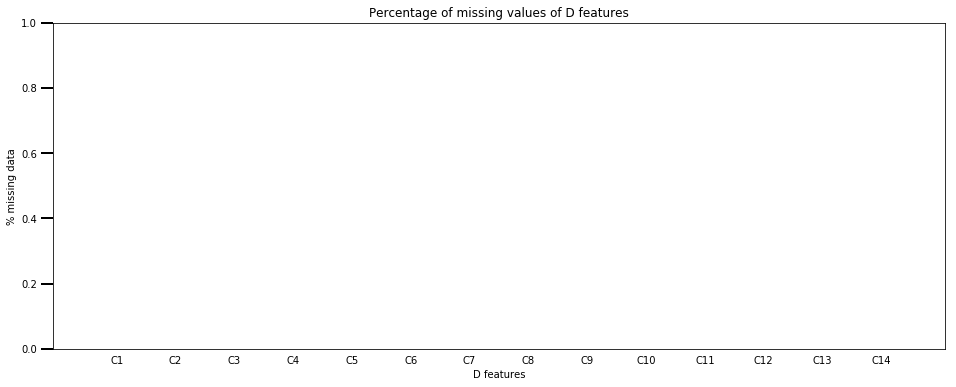

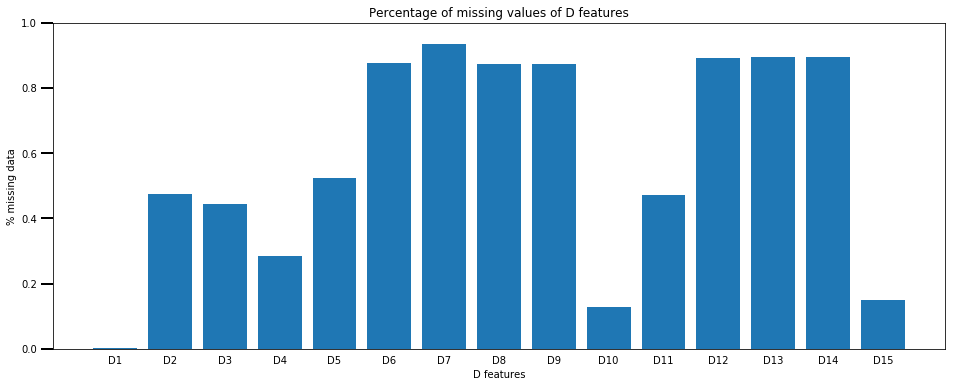

In [242]:
# plot missing percentage
plot_missing_pct(df, v_features, 'D features')
plot_missing_pct(df, c_features, 'D features')
plot_missing_pct(df, d_features, 'D features')

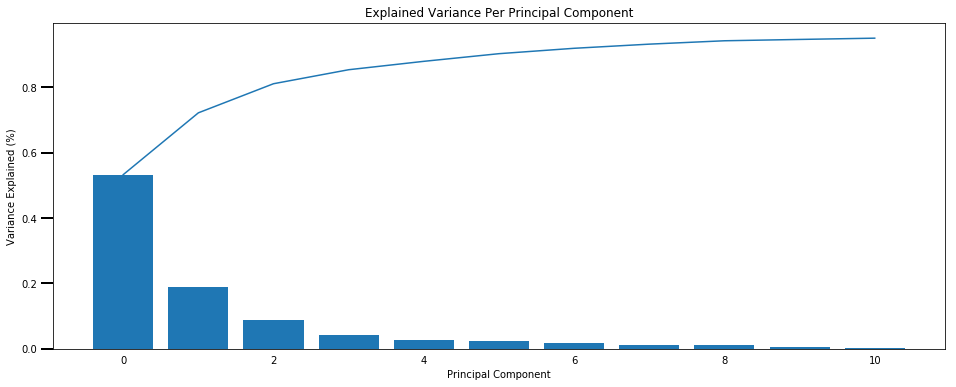

Number of Main PCA components that explained at least 95% variance : 11


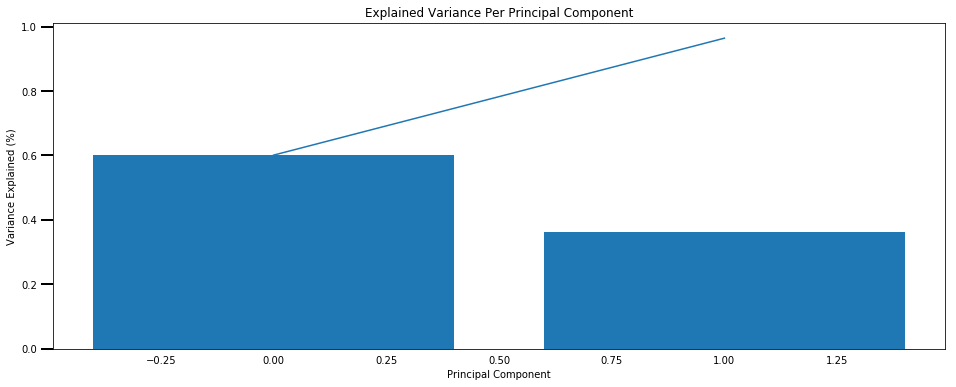

Number of Main PCA components that explained at least 95% variance : 2


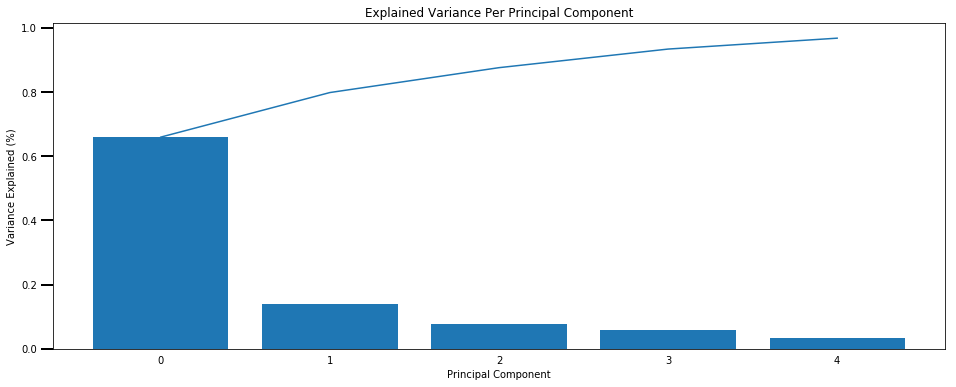

Number of Main PCA components that explained at least 95% variance : 5


In [243]:
# apply pca transformation
df, v_scaler, v_pca = pca_transform(df, v_features, 0.95, prefix = 'PCA_V_')
df, c_scaler, c_pca = pca_transform(df, c_features, 0.95, prefix = 'PCA_C_')
df, d_scaler, d_pca = pca_transform(df, d_features, 0.95, prefix = 'PCA_D_')

scree_plot(v_pca)
scree_plot(c_pca)
scree_plot(d_pca)

In [244]:
num_features.extend(df.columns[df.columns.str.contains('PCA_')].values.tolist())

##### 4.2.2 dist features

In [245]:
# dist features
pd.DataFrame(np.round(df[['dist1', 'dist2']].isnull().mean()*100), columns = ['Missing Percentage'])
# fill na for dist 1
df.loc[:, 'dist1'] = df['dist1'].fillna(-1)
# drop dist 2
df.drop(['dist2'], axis=1, inplace=True)

In [246]:
num_features.append('dist1')

##### 4.2.3 transaction features

In [247]:
# missing value check
pd.DataFrame(df[df.columns[df.columns.str.contains('Transaction')]].isnull().mean(), columns=['Missing Percentage'])

,Missing Percentage
TransactionID,0.0
TransactionDT,0.0
TransactionAmt,0.0


In [248]:
# drop transaction id
df.drop(['TransactionID'], axis=1, inplace=True)

In [249]:
# transaction dt
START_DATE = '2017-12-01'
startdate = dt.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Transaction_Date"] = df['TransactionDT'].apply(lambda x: (startdate + dt.timedelta(seconds=x)))
df['Transaction_Weekdays'] = df['Transaction_Date'].dt.dayofweek
df['Transaction_Hours'] = df['Transaction_Date'].dt.hour
df['Transaction_Days'] = df['Transaction_Date'].dt.day
df['Transaction_Months'] = df['Transaction_Date'].dt.month

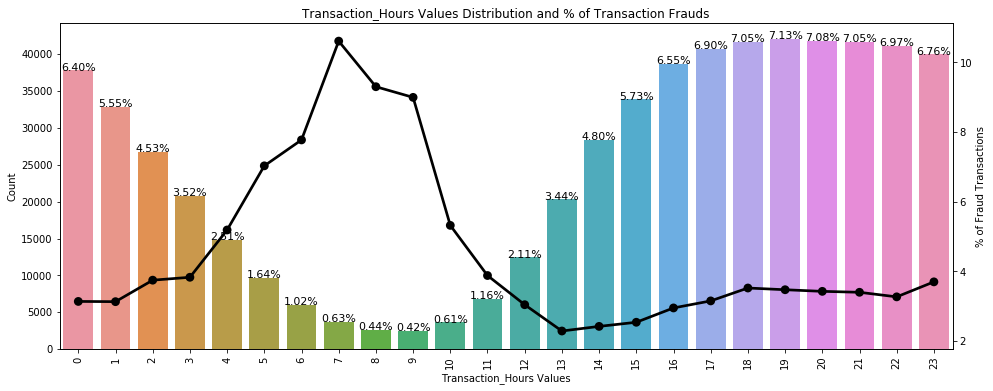

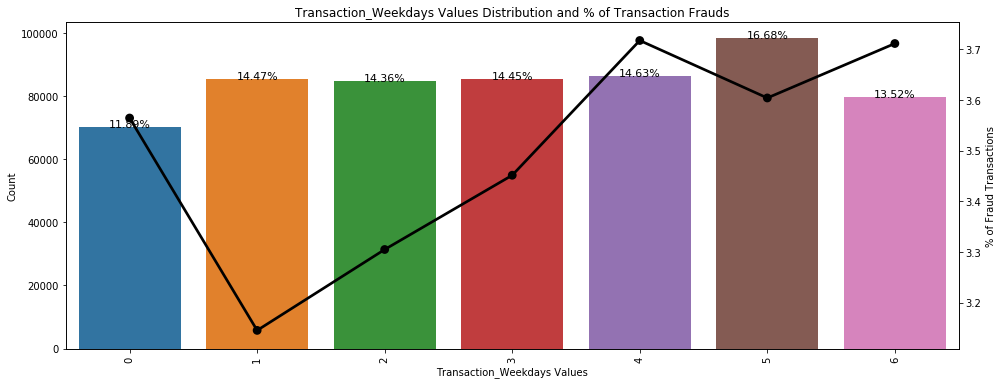

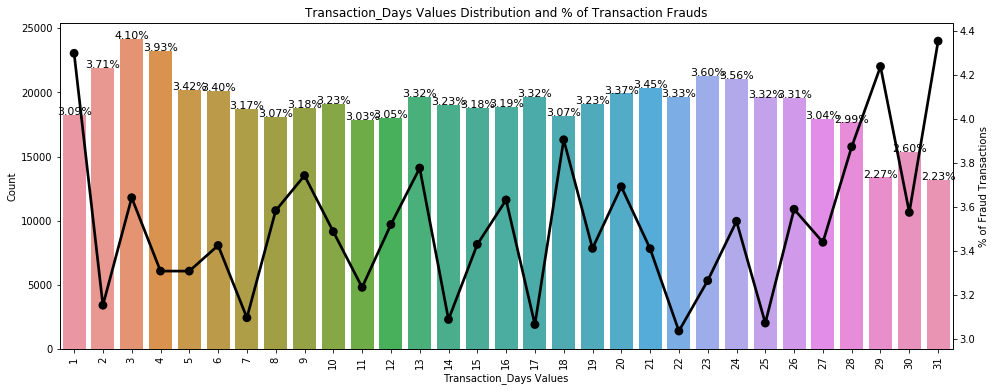

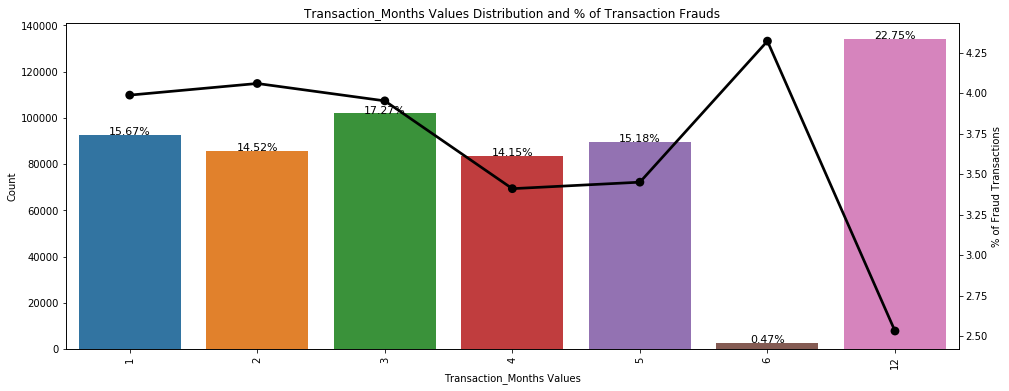

In [250]:
# plot fraud distribution by transaction dt
for col in ['Transaction_Hours', 'Transaction_Weekdays', 'Transaction_Days', 'Transaction_Months']:
    plot_dist_and_fraud_pct(df, col)

In [251]:
# transform transaction hours to categorical
df['TransactionHoursCate'] = np.where(df['Transaction_Hours'].isin([5,6,7,8,9]), 'high_risk', 'low_risk')

# drop useless transaction dt features
df.drop(df.columns[df.columns.str.contains('Transaction_')].values.tolist() + ['TransactionDT'], axis=1, inplace=True)

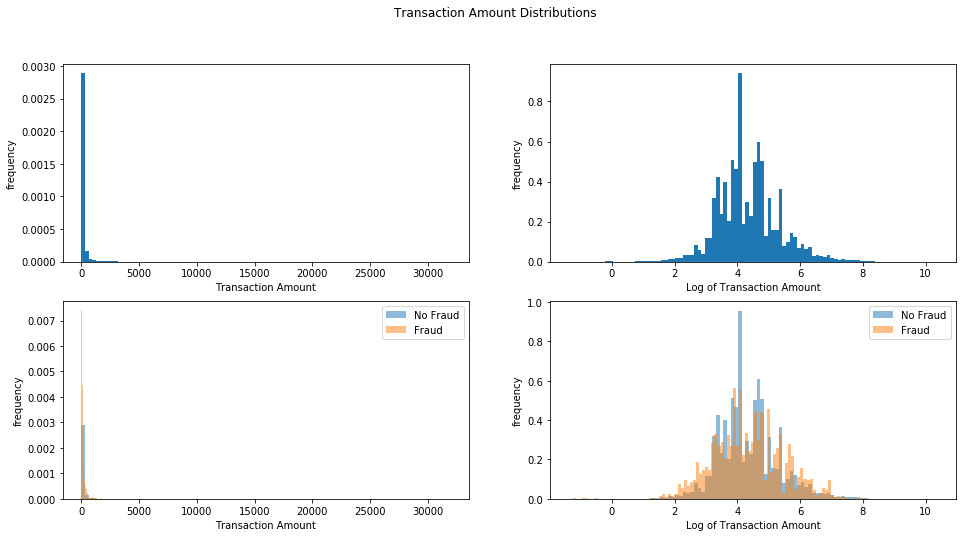

In [252]:
# transaction amount
plt.figure(figsize=(16,8))
plt.suptitle('Transaction Amount Distributions', fontsize=12)

plt.subplot(221)
plt.hist(df['TransactionAmt'], bins=100, density = True)
plt.ylabel('frequency')
plt.xlabel('Transaction Amount')

plt.subplot(222)
plt.hist(np.log(df['TransactionAmt']), bins=100, density = True)
plt.ylabel('frequency')
plt.xlabel('Log of Transaction Amount')

plt.subplot(223)
plt.hist(df.loc[df['isFraud']==0, 'TransactionAmt'], bins=100, label='No Fraud', density = True, alpha=0.5)
plt.hist(df.loc[df['isFraud']==1, 'TransactionAmt'], bins=100, label='Fraud', density = True, alpha=0.5)
plt.ylabel('frequency')
plt.xlabel('Transaction Amount')
plt.legend()

plt.subplot(224)
plt.hist(np.log(df.loc[df['isFraud']==0, 'TransactionAmt']), bins=100, label='No Fraud', density = True, alpha=0.5)
plt.hist(np.log(df.loc[df['isFraud']==1, 'TransactionAmt']), bins=100, label='Fraud', density = True, alpha=0.5)
plt.ylabel('frequency')
plt.xlabel('Log of Transaction Amount')
plt.legend()
plt.show()

# take log of Transaction amount
df.loc[:, 'TransactionAmt'] = np.log(df['TransactionAmt'])

In [253]:
cate_features.append('TransactionHoursCate')
num_features.append('TransactionAmt')

#### 4.3 ID features

In [254]:
id_features = df.columns[df.columns.str.contains('id_\d+')]
cate_id_features = ['id_'+str(x).zfill(2) for x in range(12, 38+1)]
num_id_features = ['id_'+str(x).zfill(2) for x in range(1, 12)]

In [255]:
# missing value check
num_check_df = pd.DataFrame({'Missing Percentage': np.round(df[num_id_features].isnull().mean()*100), 
              'Zero Percentage': np.round((df[num_id_features]==0).mean()*100),
              'Total Percentage': np.round((df[num_id_features].isnull()|(df[num_id_features]==0)).mean()*100)})\
            .sort_values('Total Percentage', ascending=False)
    
cate_check_df = pd.DataFrame({'Missing Percentage': np.round(df[cate_id_features].isnull().mean()*100),
                             'Nunique': df[cate_id_features].nunique()})\
            .sort_values('Missing Percentage', ascending=False)
    
# drop missing + zero values >= 99%
num_id_features_todrop = num_check_df[num_check_df['Total Percentage'] >= 99].index.values.tolist()
num_id_features_tokeep = num_check_df[num_check_df['Total Percentage'] < 99].index.values.tolist()
df.drop(num_id_features_todrop, axis=1, inplace=True)

cate_id_features_todrop = cate_check_df[cate_check_df['Missing Percentage'] >= 99].index.values.tolist()
cate_id_features_tokeep = cate_check_df[cate_check_df['Missing Percentage'] < 99].index.values.tolist()
df.drop(cate_id_features_todrop, axis=1, inplace=True)

##### 4.3.1 numerical ID features

In [256]:
num_check_df.loc[num_id_features_tokeep,:]

,Missing Percentage,Zero Percentage,Total Percentage
id_05,77.0,16.0,93.0
id_06,77.0,15.0,92.0
id_01,76.0,3.0,79.0
id_02,76.0,0.0,76.0
id_11,76.0,0.0,76.0


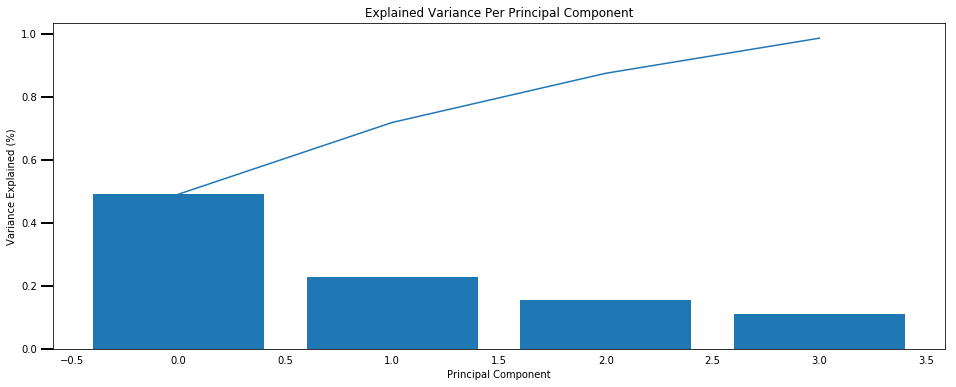

Number of Main PCA components that explained at least 95% variance : 4


In [257]:
# fill na with mode
df[num_id_features_tokeep] = df[num_id_features_tokeep].fillna(df[num_id_features_tokeep].mode().iloc[0])
# pca transformation
df, id_scaler, id_pca = pca_transform(df, num_id_features_tokeep, 0.95, prefix = 'PCA_ID_')

scree_plot(id_pca)

In [258]:
num_features.extend(df.columns[df.columns.str.contains('PCA_ID_')].values.tolist())

##### 4.3.2 categorical ID features

In [259]:
cate_check_df.loc[cate_id_features_tokeep,:]

,Missing Percentage,Nunique
id_18,92.0,18
id_33,88.0,260
id_34,87.0,4
id_32,87.0,4
id_30,87.0,75
id_14,86.0,25
id_16,78.0,2
id_13,78.0,54
id_35,76.0,2
id_31,76.0,130


In [260]:
# int to float
cate_id_features_to_int = df[cate_id_features_tokeep].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, cate_id_features_to_int] = df.loc[:, cate_id_features_to_int].astype('Int64')

# int to str
df.loc[:, cate_id_features_to_int] = df.loc[:, cate_id_features_to_int].astype(str)

# fill na with None
df[cate_id_features_tokeep] = df[cate_id_features_tokeep].fillna('None')

In [261]:
# id - system
df['sys_id_30'] = df['id_30'].str.split(' ').str[0]
sys_list = ['Windows', 'iOS', 'Mac', 'Android', 'Linux', 'None']
df['sys_id_30'] = np.where(df['sys_id_30'].isin(sys_list), df['sys_id_30'], 'None')

# id - browser
browsers = {'safari': 'safari', 'chrome': 'chrome', 'samsung': 'samsung', 'Samsung': 'samsung', 'edge': 'edge', 
 'firefox': 'firefox', 'ie':'ie', 'google':'google', 'other':'others', 'None':'None'}
browsers_list = ['chrome','safari','ie','firefox','edge','samsung','None']
for k,v in browsers.items():
    df.loc[df['id_31'].str.contains(k, na=False), 'browser_id_31'] = v
df.loc[~df['browser_id_31'].isin(browsers_list), 'browser_id_31'] = 'others'

# id - screen
df.loc[df['id_33']=='0x0', 'id_33'] = 'None'
screen_width = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[0].astype(int)
bins = [0, 900, 1500, np.inf]
screen_height_cate = pd.cut(screen_height, bins, labels=['s', 'm', 'l'])

screen_height = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[1].astype(int)
bins = [0, 1200, 2000, np.inf]
screen_width_cate = pd.cut(screen_width, bins, labels=['s', 'm', 'l'])

screen = screen_width_cate.astype(str) + 'x' + screen_height_cate.astype(str)
df.loc[df['id_33']!='None', 'screen_id_33'] = screen
df.loc[df['id_33']=='None', 'screen_id_33'] = 'None'

# drop id 30, 31, 33
df.drop(['id_30','id_31','id_33'], axis=1, inplace=True)
cate_id_features_tokeep.remove('id_30')
cate_id_features_tokeep.remove('id_31')
cate_id_features_tokeep.remove('id_33')

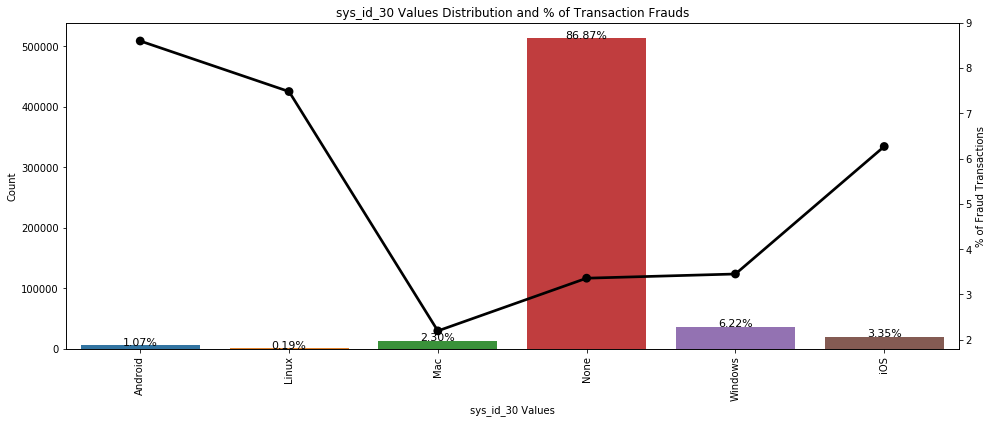

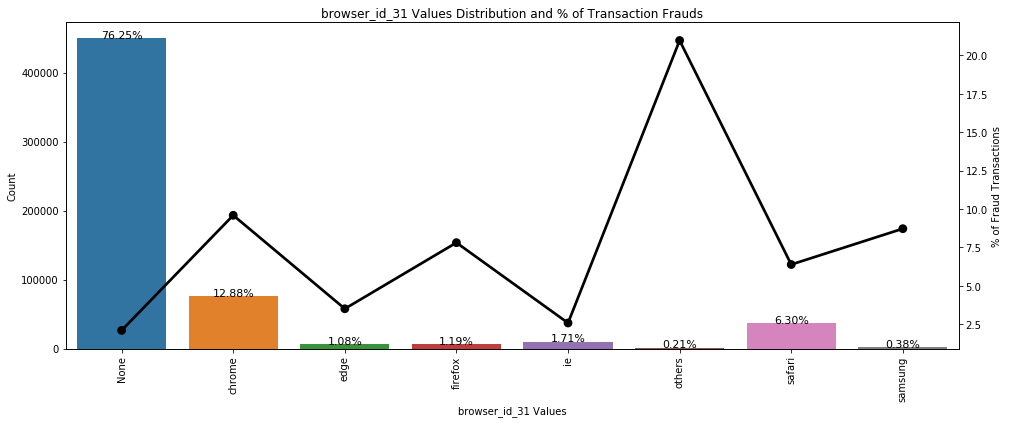

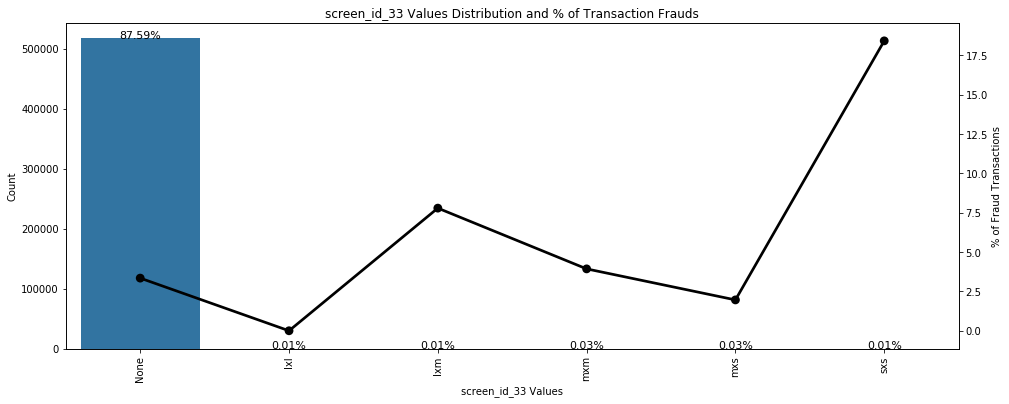

In [262]:
for col in ['sys_id_30', 'browser_id_31', 'screen_id_33']:
    plot_dist_and_fraud_pct(df, col)

------------------------------------------------------------------------------------------------------------
id_18 has 19 unique levels.
top 2 levels account for 96.7% of the total population.


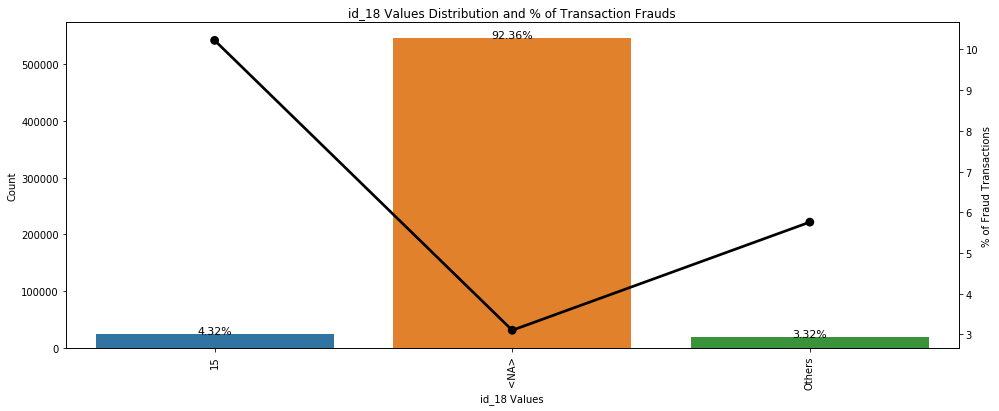

------------------------------------------------------------------------------------------------------------
id_34 has 5 unique levels.
top 2 levels account for 97.0% of the total population.


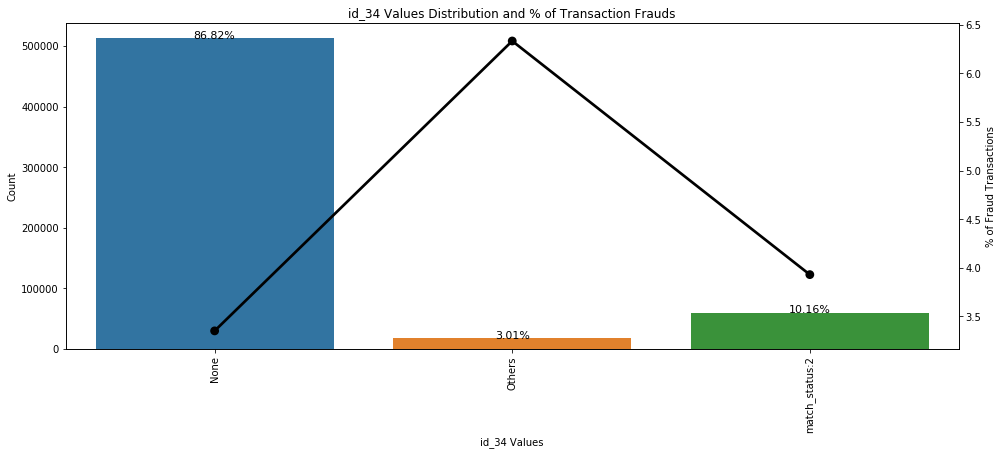

------------------------------------------------------------------------------------------------------------
id_32 has 5 unique levels.
top 2 levels account for 95.8% of the total population.


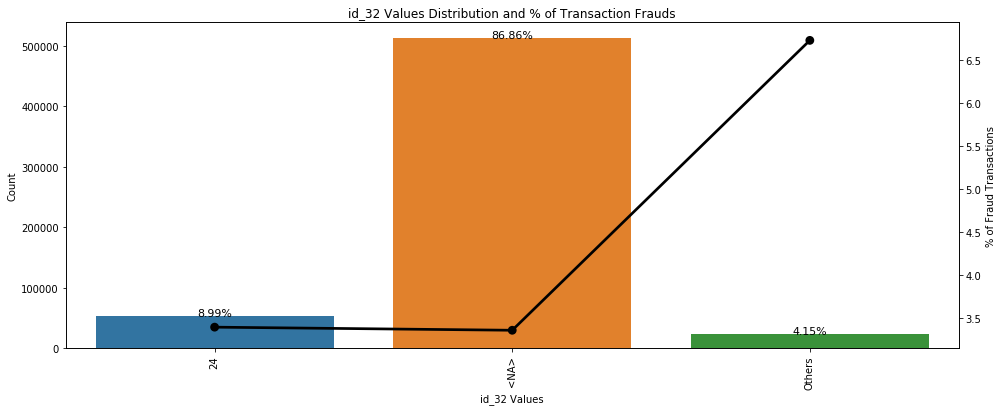

------------------------------------------------------------------------------------------------------------
id_14 has 26 unique levels.
top 2 levels account for 93.9% of the total population.


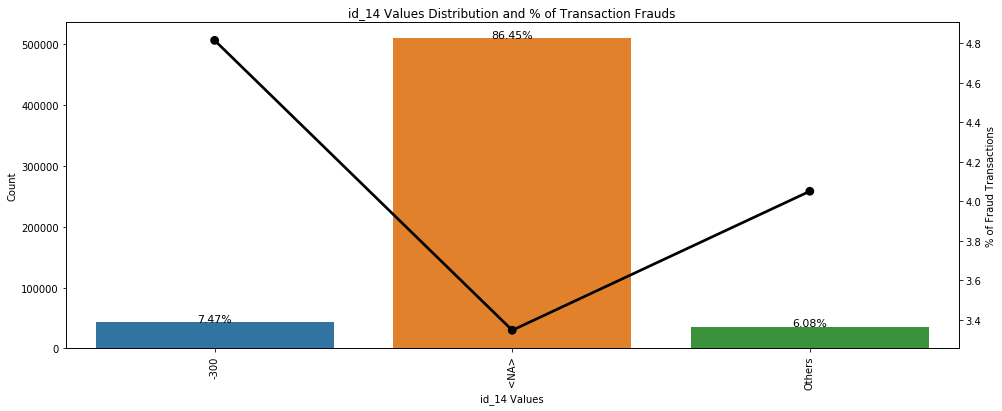

------------------------------------------------------------------------------------------------------------
id_16 has 3 unique levels.
top 2 levels account for 89.3% of the total population.


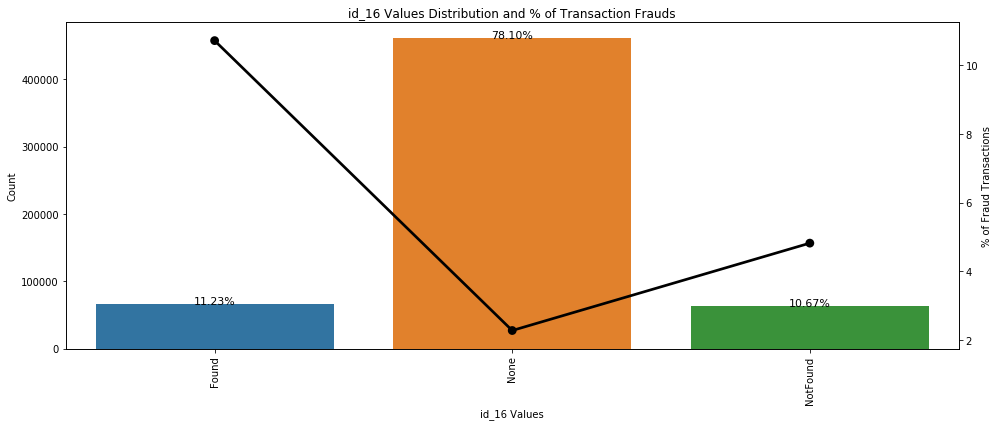

------------------------------------------------------------------------------------------------------------
id_13 has 55 unique levels.
top 3 levels account for 92.7% of the total population.


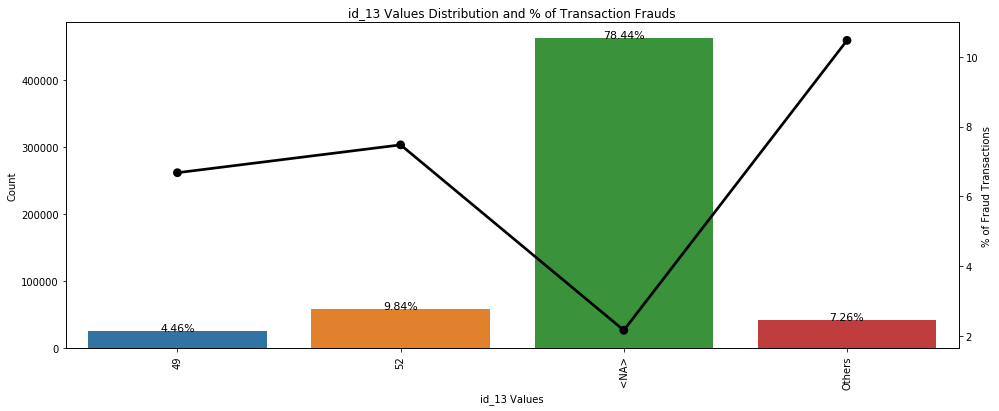

------------------------------------------------------------------------------------------------------------
id_35 has 3 unique levels.
top 2 levels account for 89.3% of the total population.


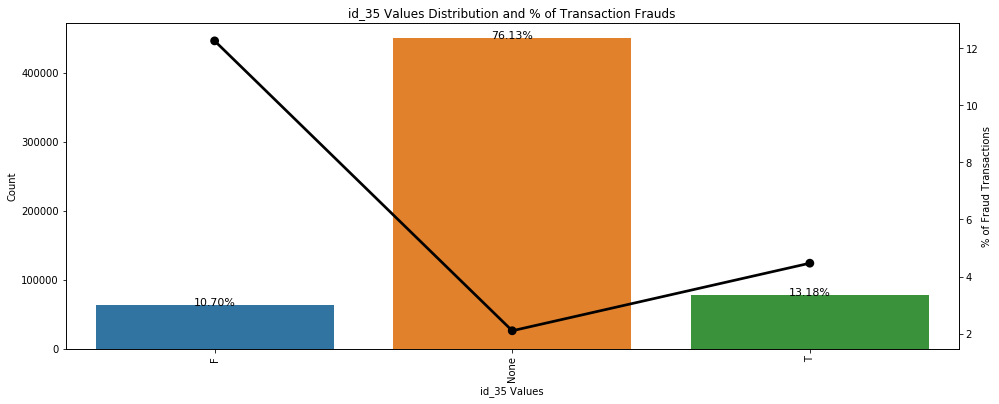

------------------------------------------------------------------------------------------------------------
id_36 has 3 unique levels.
top 2 levels account for 98.8% of the total population.


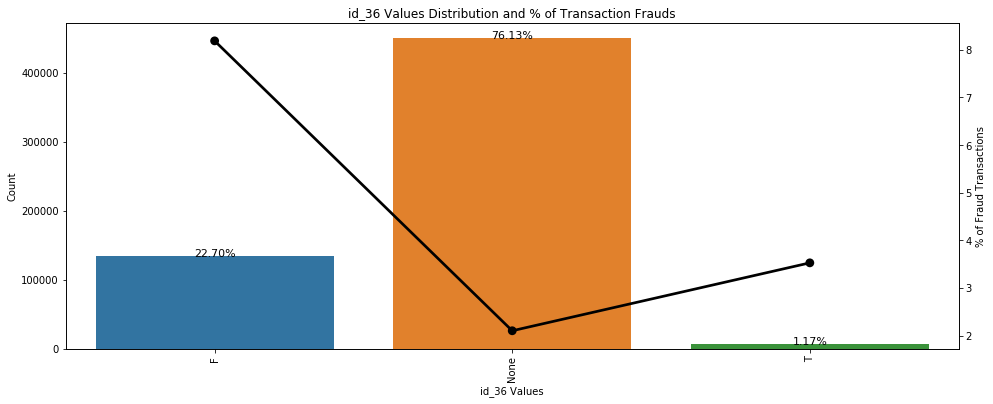

------------------------------------------------------------------------------------------------------------
id_37 has 3 unique levels.
top 2 levels account for 94.8% of the total population.


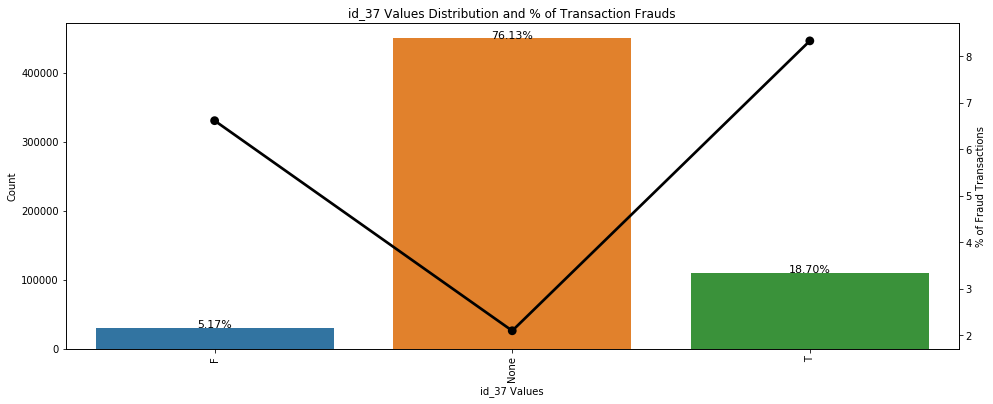

------------------------------------------------------------------------------------------------------------
id_12 has 3 unique levels.
top 2 levels account for 96.4% of the total population.


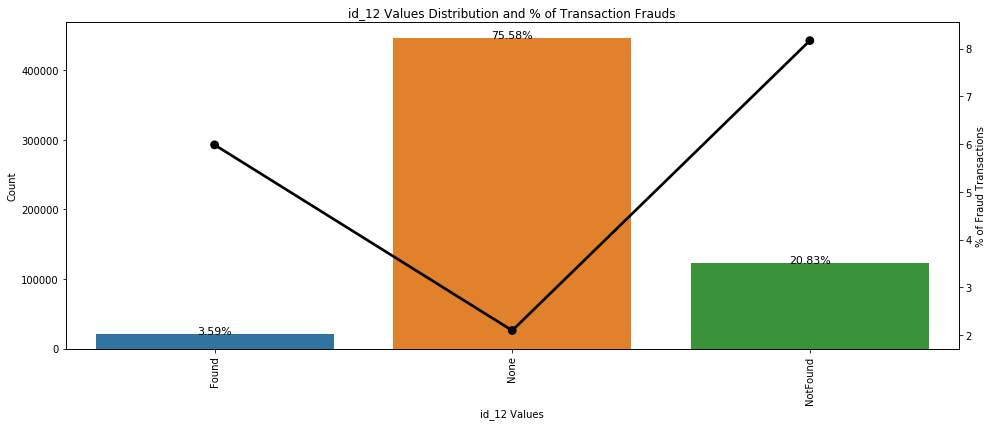

------------------------------------------------------------------------------------------------------------
id_29 has 3 unique levels.
top 2 levels account for 88.8% of the total population.


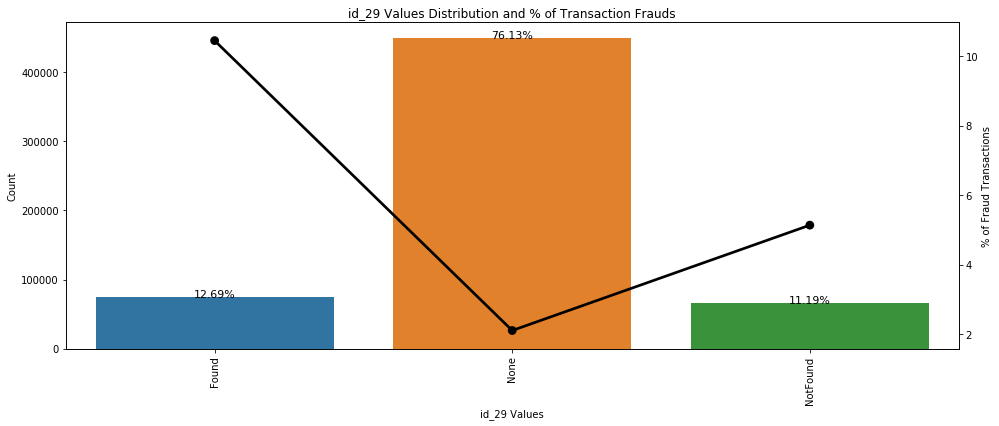

------------------------------------------------------------------------------------------------------------
id_28 has 3 unique levels.
top 2 levels account for 89.0% of the total population.


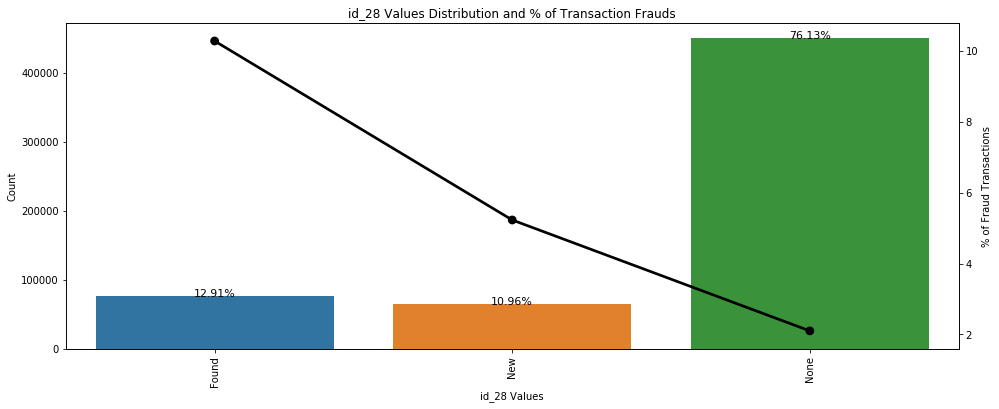

------------------------------------------------------------------------------------------------------------
id_20 has 395 unique levels.
top 26 levels account for 94.9% of the total population.
------------------------------------------------------------------------------------------------------------
id_20 has 27 unique levels.
top 6 levels account for 89.6% of the total population.


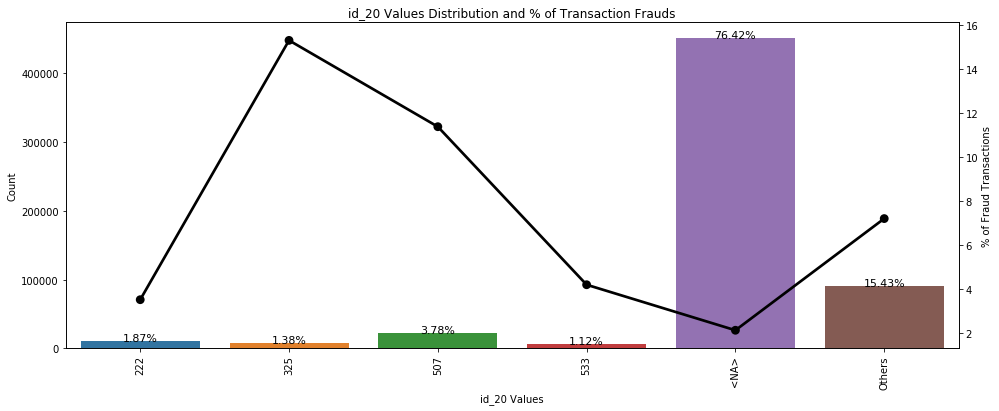

------------------------------------------------------------------------------------------------------------
id_19 has 523 unique levels.
top 23 levels account for 95.0% of the total population.
------------------------------------------------------------------------------------------------------------
id_19 has 24 unique levels.
top 6 levels account for 89.6% of the total population.


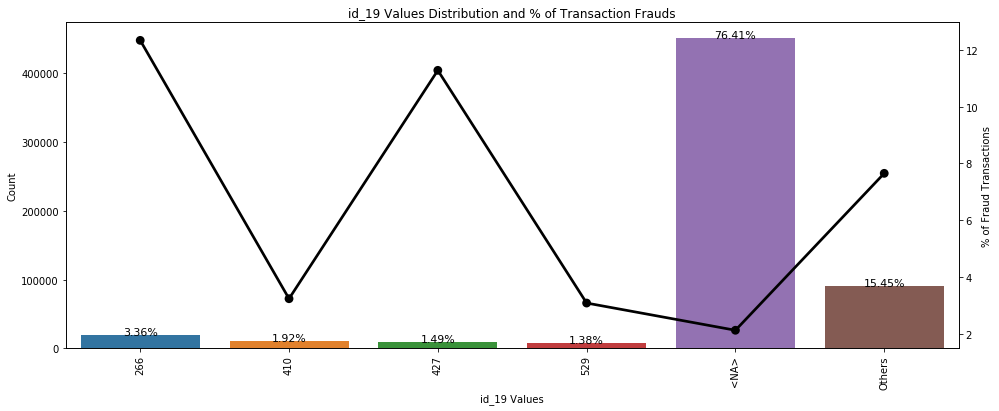

------------------------------------------------------------------------------------------------------------
id_17 has 105 unique levels.
top 2 levels account for 89.7% of the total population.


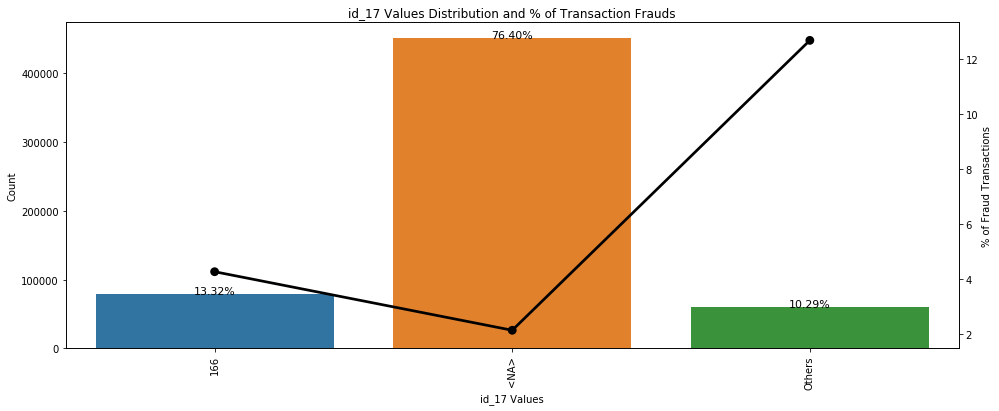

------------------------------------------------------------------------------------------------------------
id_15 has 4 unique levels.
top 2 levels account for 87.6% of the total population.


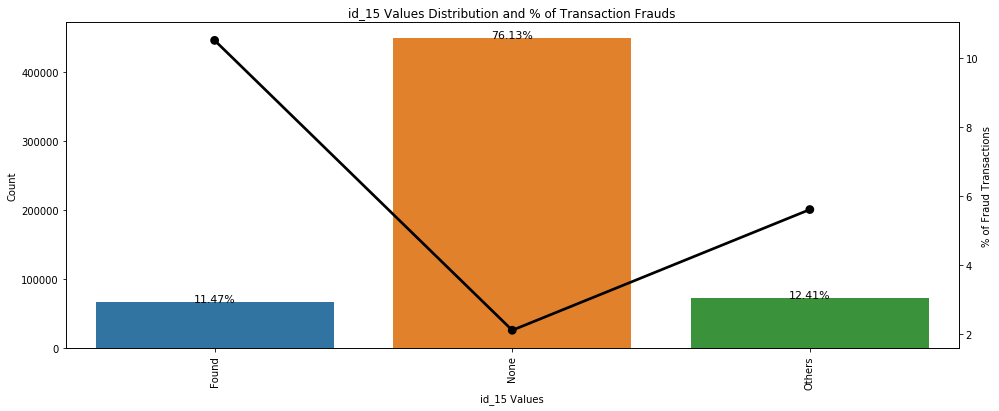

------------------------------------------------------------------------------------------------------------
id_38 has 3 unique levels.
top 2 levels account for 88.6% of the total population.


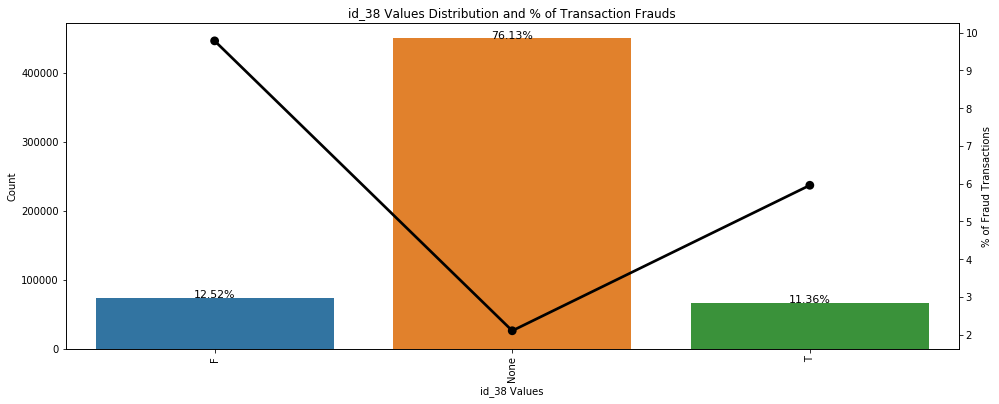

In [263]:
# clean categorical features
for col in cate_id_features_tokeep:
    df, top_levels = keep_top_levels(df, col)
    if len(top_levels) > 10:
        df, top_levels = keep_top_levels(df, col, 0.9)
    plot_dist_and_fraud_pct(df, col)

In [264]:
cate_id_features_tokeep.extend(['sys_id_30', 'browser_id_31', 'screen_id_33'])
cate_features.extend(cate_id_features_tokeep)

In [267]:
len(df.columns)

69

In [266]:
len(cate_features)+len(num_features)

68

#### 4.4 Encoding

In [268]:
# label encoding
for col in cate_features:
    le = LabelEncoder()
    le.fit(list(df[col].astype(str).values))
    df[col] = le.transform(list(df[col].astype(str).values))

In [227]:
# onehot encoding + pca
drop_enc = OneHotEncoder(drop='first')
drop_enc.fit(X[cate_features])
encoded_X_cate = drop_enc.transform(X[cate_features])

In [230]:
encoded_X_cate

<5000x186 sparse matrix of type '<class 'numpy.float64'>'
	with 170258 stored elements in Compressed Sparse Row format>

In [229]:
pca = PCA(0.95, random_state = 0)
principalComponents = pca.fit_transform(encoded_X_cate)
principalDF = pd.DataFrame(principalComponents, columns = ['PCA_CATE_'+str(x) for x in range(1, principalComponents.shape[1]+1)])


TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

### 5 Modelling

In [269]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

# X_test = test.drop(['TransactionDT'], axis=1)

In [204]:
# LightGBM
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)
splits = folds.split(X, y)
# y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, 
                    dtrain, 
                    10000, 
                    valid_sets = [dtrain, dvalid], 
                    verbose_eval=200, 
                    early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    # y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

NameError: name 'lgb' is not defined

In [ ]:
params = {'bagging_fraction': 0.9, 
          'colsample_bytree': 0.75, 
          'feature_fraction': 0.8, 
          'gamma': 0.67, 
          'learning_rate': 0.015, 
          'max_depth': 16, 
          'min_child_samples': 170, 
          'num_leaves': 220, 
          'reg_alpha': 0.4, 
          'reg_lambda': 0.25, 
          'subsample': 0.7}

In [ ]:
# XGBoost
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)
splits = folds.split(X, y)
# y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
feature_importances = feature_importances.set_index('feature')

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    clf = xgb.XGBClassifier(
            n_estimators=600, 
            random_state=0, 
            verbose=True, 
            #tree_method='gpu_hist', 
            **params
        )
    clf.fit(X_train, y_train)
    
    feature_important = clf.get_booster().get_score(importance_type="weight")
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    feature_importances.loc[keys, f'fold_{fold_n + 1}'] = values
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    # y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

In [ ]:
# XGBoost

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)